In [ ]:
!pip install yahoo_fin
!pip install yfinance

In [2]:
import time
import pandas as pd
from datetime import date
from yahoo_fin import options
import yfinance as yf
import numpy as np
import math

# **Overview:**

A common way to predict future realized volatility is by directly obtaining implied volatility (IV) from the market. 

This is arguably more reliable than building models to forecast it based on historical volatility. 


How to obtain IV from the market:


* **Method 1:**

 Using the Black Scholes Model, set the price of the option equal to the quoted market price, then holding all variables constant and letting IV as the unknown variable, solve for sigma. The solved value is our IV.
 
 When solving for sigma, we can validate whether implied volatility is correct by: (1) checking that the model's price is being closely equal to the option's market price, and (2) the delta should be extremely close to 50. 


* **Method 2** (*Shortcut*): 

 There is actually no need for us to solve IV by ourselves through coding. The option chain provided by Yahoo Finance has the IVs for each individual contract. We just need to look up options that are at-the-money or near-the-money.

This script will be an implementation of **Method 2**. We will go further by looking up the IVs of an option at the same strike price but across different maturities. This information will be useful when considering or calendar spread strategies, and for understanding the term structure of options for specific underlying assets. 

In [3]:
# Manual inputs:
symbol                   = "TSLA" 
riskfree_rate            = math.e**(.0395)-1
date_today               = date(2023,2,28)  # for crnt_price

In [4]:
ticker_yahoo = yf.Ticker(symbol)
data = ticker_yahoo.history()
crnt_price = data['Close'].iloc[-1]
crnt_price

205.7100067138672

In [5]:
def _get_iv(chain):
  ''' get_iv(Object)
      @param Object : chain, an object from options.get_options_chain()
      Returns implied volatility as float. 
  '''
  iv = None
  for i in range(len(chain)-1):
      c = chain["Strike"]
      if c[i+1] >= crnt_price and c[i] <= crnt_price:
        iv = chain["Implied Volatility"][i]
        break
  return float(iv.strip("%"))/100

In [6]:
def get_iv(type_options):
  ''' get_iv(string)
      @param string : type_options, either "calls" or "puts"
      Returns tuple of (A) list of expiry dates, and (B) list of IV
  '''
  list_iv = [] 
  list_expdates= []
  for date_expire_str in options.get_expiration_dates(symbol):
    tmp = options.get_options_chain(symbol, date_expire_str)[type_options]
    iv = _get_iv(tmp)
    list_expdates.append(date_expire_str)
    list_iv.append(iv)
    print("{}; ATM Call; iv={}".format(date_expire_str, round(iv,4)))
  return (list_expdates, list_iv)

In [7]:
list1, list2 = get_iv("calls")

March 3, 2023; ATM Call; iv=0.9414
March 10, 2023; ATM Call; iv=0.7446
March 17, 2023; ATM Call; iv=0.6987
March 24, 2023; ATM Call; iv=0.6836
March 31, 2023; ATM Call; iv=0.6656
April 6, 2023; ATM Call; iv=0.6854
April 21, 2023; ATM Call; iv=0.6954
May 19, 2023; ATM Call; iv=0.674
June 16, 2023; ATM Call; iv=0.6523
July 21, 2023; ATM Call; iv=0.6522
September 15, 2023; ATM Call; iv=0.638
November 17, 2023; ATM Call; iv=0.6526
December 15, 2023; ATM Call; iv=0.6368
January 19, 2024; ATM Call; iv=0.6371
March 15, 2024; ATM Call; iv=0.6403
June 21, 2024; ATM Call; iv=0.6419
September 20, 2024; ATM Call; iv=0.6414
January 17, 2025; ATM Call; iv=0.6431
June 20, 2025; ATM Call; iv=0.6364


In [8]:
np.average(np.array(list2))

0.676884210526316

###Calls:

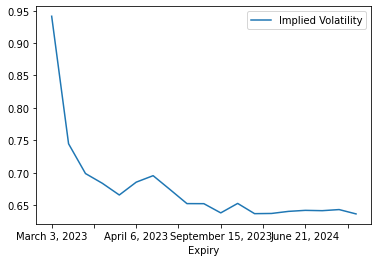

In [15]:
pd.DataFrame({ "Expiry":list1, "Implied Volatility":list2 }).plot(x="Expiry", y="Implied Volatility");

**Observations:**


Can see "half cone shape**" forming. As time to maturity increases (ie expiration is further away from today's date) we see implied volatility converging to a lower value.


We can assume this lower value to be the long-term mean volatility, although periodicity can be a separate subject of discussion. 

On a separate study (using TradingView***), I'm using EWMA to estimate the historical volatility:

* on TSLA daily, applying 252 period lookback
* annualization of HV using t=252
* results: EWMA HV is .6912, with median .6479; somewhat aligns with current IV and expected mean that this plot is converging to

<br>
** It's a half-cone-shape because if IV is currently extremely low, then we can expect it converging upwards to, say, .6479. Put together these two scenarios, then you get a cone pointing to the right side of the x-axis.
<br>
<br>
*** TradingView study: Refer to the marked red circle:




 


![link text](https://s3.tradingview.com/snapshots/e/ejzKZ85O.png)

Let's look at Puts, it should have a similar shape. 

In [16]:
list1, list2 = get_iv("puts")

March 3, 2023; ATM Call; iv=0.8955
March 10, 2023; ATM Call; iv=0.714
March 17, 2023; ATM Call; iv=0.6696
March 24, 2023; ATM Call; iv=0.6483
March 31, 2023; ATM Call; iv=0.6282
April 6, 2023; ATM Call; iv=0.6405
April 21, 2023; ATM Call; iv=0.6477
May 19, 2023; ATM Call; iv=0.615
June 16, 2023; ATM Call; iv=0.5844
July 21, 2023; ATM Call; iv=0.5731
September 15, 2023; ATM Call; iv=0.5482
November 17, 2023; ATM Call; iv=0.5466
December 15, 2023; ATM Call; iv=0.5257
January 19, 2024; ATM Call; iv=0.5183
March 15, 2024; ATM Call; iv=0.5136
June 21, 2024; ATM Call; iv=0.5021
September 20, 2024; ATM Call; iv=0.495
January 17, 2025; ATM Call; iv=0.482
June 20, 2025; ATM Call; iv=0.4673


###Puts:

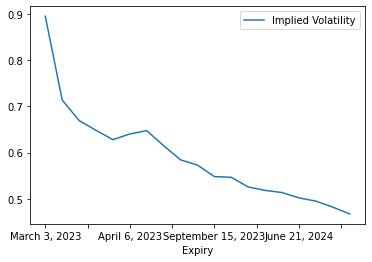

In [17]:
pd.DataFrame({ "Expiry":list1, "Implied Volatility":list2 }).plot(x="Expiry", y="Implied Volatility");

In [18]:
np.average(np.array(list2))

0.5902684210526314